## Calculando Largura de vias

A intenção aqui é experimentar uma metodoloogia para se calcular a larura de vias dadas as seguintes feições:
* Um polígono da via
* Uma linha aproximada ao trajeto central da via
* Poligono com as quadras adjacentes a via

Para tanto disponibilizamos um arquivo que podemos acessar assim:

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df_pvias = gpd.read_file("./gis/POC-largura-de-via.gpkg", layer='poligono-de-vias')

In [3]:
df_lvias = gpd.read_file("./gis/POC-largura-de-via.gpkg", layer='logradouros')

In [4]:
df_quadras = gpd.read_file("./gis/POC-largura-de-via.gpkg", layer='quadras')

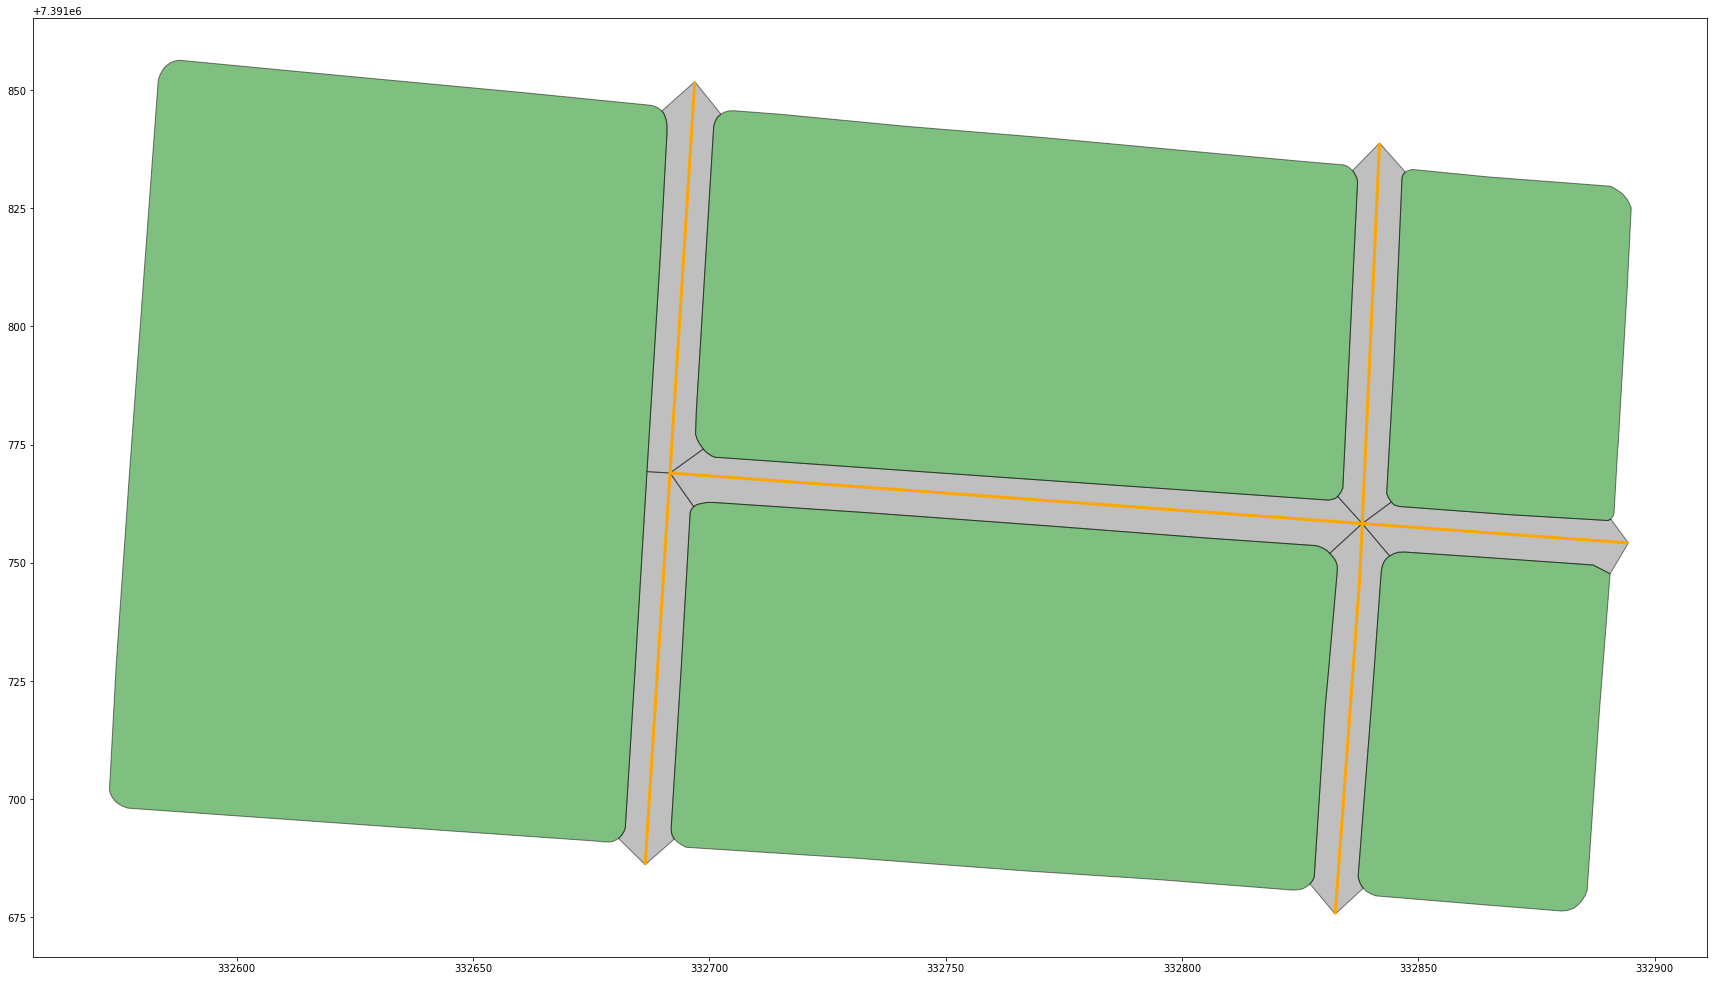

In [21]:
f, ax = plt.subplots(1, figsize=(30,20))
df_pvias.plot(ax=ax, color="grey", alpha=0.5, linewidth=1, edgecolor='black')
df_lvias.plot(ax=ax, color="orange", lw=3)
df_quadras.plot(ax=ax, color="green", alpha=0.5, linewidth=1, edgecolor='black')

## Dividir para conquistar

Primeira estratégia seria dividir a linha central da via em pequenos segmentos para depois encontrar os pontos próximos nas quadras adjacentes

In [48]:
df_lvias.apply(lambda x: [x.geometry.length], axis=1)

0     [82.84273643904555]
1     [80.59425436230332]
2     [82.95592474412558]
3     [83.04766092811225]
4    [146.85586684383873]
5     [56.47167724829081]
dtype: object

Uma estratégia que pode parecer interessante seria gerar um ponto a cada 10 metros para medirmos e exluir o último ponto de modo que fique distante do cruzamento com outra via

In [229]:
import math
from shapely.geometry import MultiPoint
points = df_lvias.apply(lambda x: MultiPoint([x.geometry.interpolate((i+1)*10) 
                                              for i in range(math.floor(x.geometry.length/10) - 1)]), 
                        axis=1)

df_points = gpd.GeoDataFrame(geometry=points)

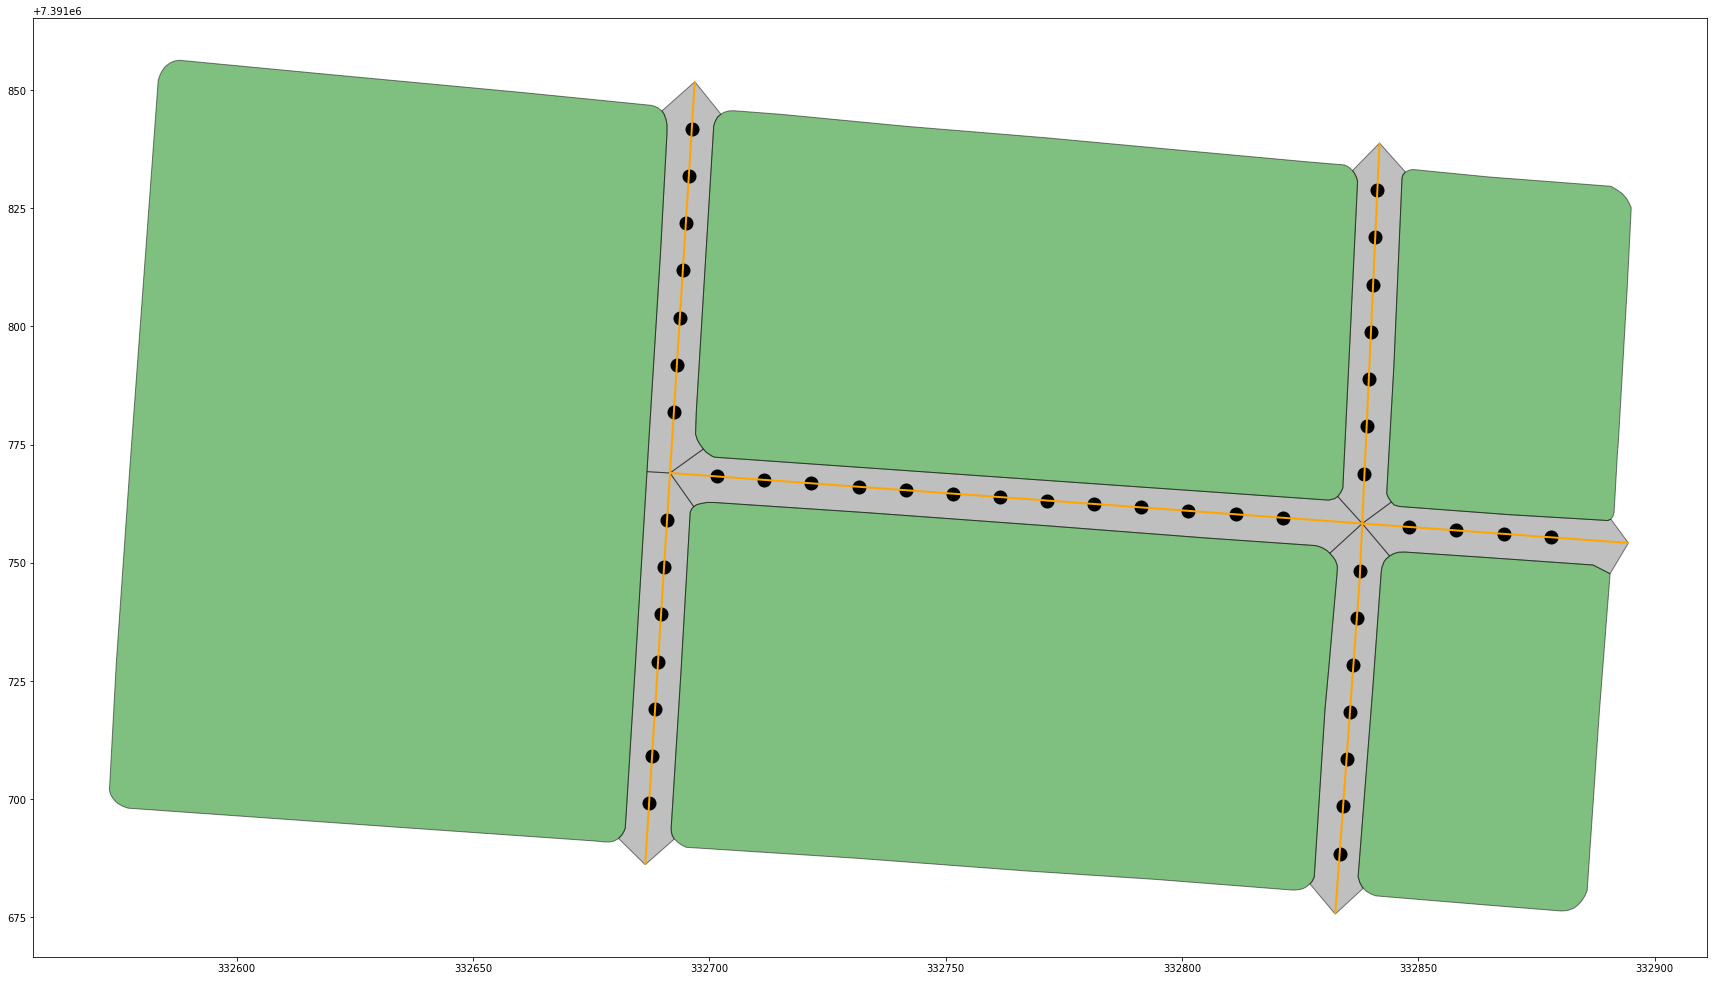

In [230]:
f, ax = plt.subplots(1, figsize=(30,20))
df_pvias.plot(ax=ax, color="grey", alpha=0.5, linewidth=1, edgecolor='black')
df_lvias.plot(ax=ax, color="orange", lw=2)
df_quadras.plot(ax=ax, color="green", alpha=0.5, linewidth=1, edgecolor='black')
df_points.plot(ax=ax, lw=4, marker='o', markersize=100, color='black')

Agora temos que relacionar esses pontos seu respectivo polígono de via para depois saber quais são as suas quadras adjacentes, para então medir a sua distância até elas

## Relacionando o ponto ao seu polígono de via

In [231]:
gpd.sjoin(df_points, df_pvias, how='left', op='intersects')

,geometry,index_right
0,"MULTIPOINT (332837.669 7391748.308, 332836.987...",0
1,"MULTIPOINT (332841.332 7391828.819, 332840.878...",4
2,"MULTIPOINT (332696.270 7391841.801, 332695.637...",5
3,"MULTIPOINT (332691.026 7391759.011, 332690.394...",1
4,"MULTIPOINT (332701.631 7391768.263, 332711.605...",3
5,"MULTIPOINT (332848.097 7391757.570, 332858.071...",2


Seria interessante talvez termos um registro para cada ponto

In [232]:
points = df_points.apply(lambda x: list(x.geometry.geoms), axis=1)
df_p = gpd.GeoDataFrame(geometry=[item for sublist in points for item in sublist])

In [233]:
df_points = gpd.sjoin(df_p, df_pvias, how='left', op='intersects', rsuffix='pvias')
df_points

,geometry,index_pvias
0,POINT (332837.669 7391748.308),0
1,POINT (332836.987 7391738.332),0
2,POINT (332836.259 7391728.359),0
3,POINT (332835.531 7391718.385),0
4,POINT (332834.803 7391708.412),0
5,POINT (332834.075 7391698.438),0
6,POINT (332833.347 7391688.465),0
7,POINT (332841.332 7391828.819),4
8,POINT (332840.878 7391818.830),4
9,POINT (332840.423 7391808.840),4


## Relacionando as quadras adjacentes ao polígono de vias

Agora precisamos saber quais são as quadras adjacentes ao polígono de vias e essa é uma das vantagens de se trabalhar com um polígono e não com linhas para representar vias.

In [234]:
df_pvia_quadra = gpd.sjoin(df_pvias, df_quadras, how='left', op='intersects', rsuffix='quadra')
df_pvia_quadra.index.name = 'id'
df_pvia_quadra

,geometry,index_quadra,qe_escala,qe_ano_ref,qe_area,qe_id,qe_tipo
id,,,,,,,
0,"POLYGON ((332838.357 7391681.144, 332832.412 7...",2,1:1.000,2004,9975.0,12243.0,Quadra
0,"POLYGON ((332838.357 7391681.144, 332832.412 7...",3,1:1.000,2004,3523.0,12242.0,Quadra
1,"POLYGON ((332692.571 7391691.545, 332686.408 7...",1,1:1.000,2004,17156.0,12244.0,Quadra
1,"POLYGON ((332692.571 7391691.545, 332686.408 7...",2,1:1.000,2004,9975.0,12243.0,Quadra
2,"POLYGON ((332890.572 7391747.677, 332886.974 7...",3,1:1.000,2004,3523.0,12242.0,Quadra
2,"POLYGON ((332890.572 7391747.677, 332886.974 7...",4,1:1.000,2004,3427.0,9221.0,Quadra
3,"POLYGON ((332831.250 7391752.001, 332830.666 7...",0,1:1.000,2004,9889.0,12544.0,Quadra
3,"POLYGON ((332831.250 7391752.001, 332830.666 7...",2,1:1.000,2004,9975.0,12243.0,Quadra
4,"POLYGON ((332844.298 7391762.855, 332838.124 7...",0,1:1.000,2004,9889.0,12544.0,Quadra


Agora podemos relacionar os pontos ao DataFrame de poligonos de vias e quadras que acabamos de criar

## Calculando as distâncias

Agora podemos a partir de cada ponto, calcular a distância para cada quadra adjacente ao seu respectivo polígono de via.

Na maioria dos casos vamos ter apenas duas quadras adjacentes, mas é possível acontecer casos em que há apenas uma e mais do que duas.

Nos casos onde só exista uma quadra adjacente podemos desconsiderar o cálculo. 

Nos casos onde ocorrerem mais do que duas quadras adjacentes, vamos utilizar as duas medidas mais próximas, o que faz sentido, uma vez que buscamos a largura mínima da via.


In [235]:
from shapely.ops import nearest_points
from shapely.geometry import LineString

def calc_distancia(p):
    quadras = list(df_pvia_quadra[df_pvia_quadra.index == p.index_pvias].index_quadra)
    quadras = df_quadras[df_quadras.index.isin(quadras)]
    pontos  = []
    
    for i, row in quadras.iterrows():
        pontos.append(nearest_points(p.geometry, row.geometry)[1])
        
    return LineString(pontos)

df_dists = gpd.GeoDataFrame(geometry=df_points.apply(lambda x: calc_distancia(x), axis=1))

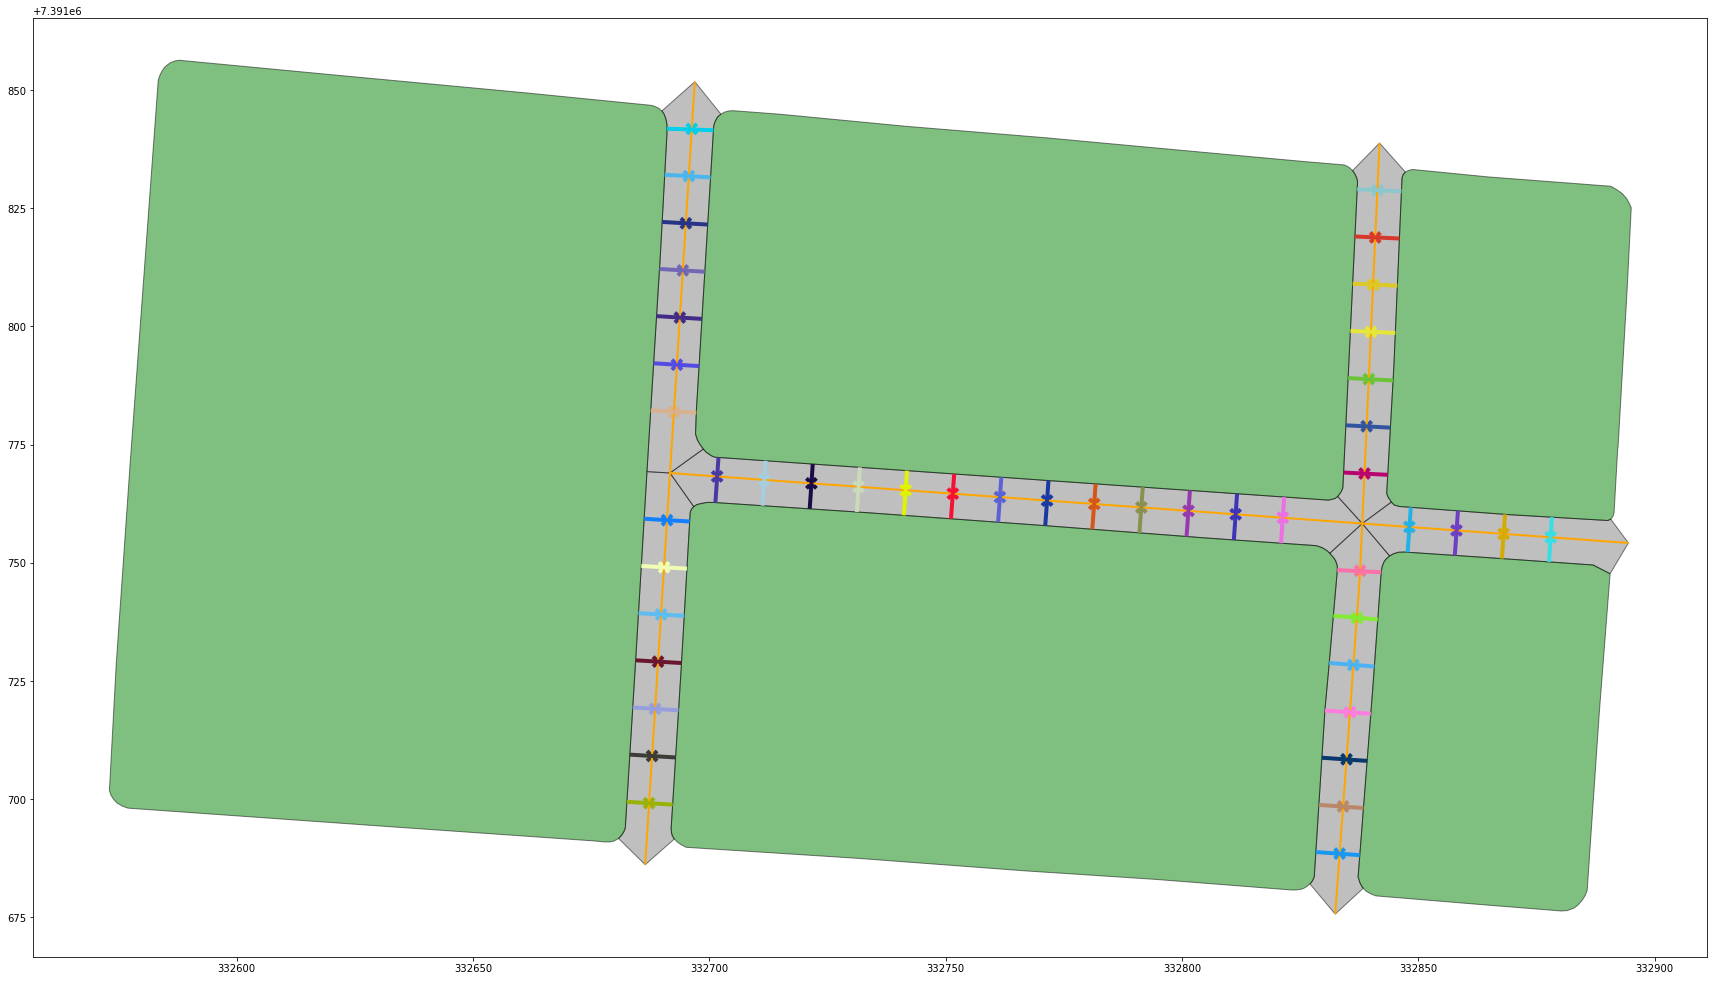

In [240]:
import numpy as np
f, ax = plt.subplots(1, figsize=(30,20))
df_pvias.plot(ax=ax, color="grey", alpha=0.5, linewidth=1, edgecolor='black')
df_lvias.plot(ax=ax, color="orange", lw=2)
df_quadras.plot(ax=ax, color="green", alpha=0.5, linewidth=1, edgecolor='black')

c = np.random.rand(len(df_dists), 3)

df_dists.plot(ax=ax,lw=4, color=c)
df_points.plot(ax=ax, lw=4, marker='x', markersize=100, color=c)

In [237]:
df_dists.length

0     9.316993
1     9.432775
2     9.580650
3     9.735180
4     9.598375
5     9.461569
6     9.324763
7     9.375321
8     9.422495
9     9.469669
10    9.516844
11    9.524105
12    9.439609
13    9.355114
14    9.840298
15    9.718728
16    9.652861
17    9.609927
18    9.620401
19    9.630874
20    9.651152
21    9.648384
22    9.671848
23    9.695313
24    9.718777
25    9.711604
26    9.702838
27    9.694073
28    9.569708
29    9.536054
30    9.502399
31    9.468745
32    9.483268
33    9.511254
34    9.539239
35    9.567225
36    9.632757
37    9.701764
38    9.771496
39    9.799547
40    9.795522
41    9.528503
42    9.451289
43    9.387429
44    9.483174
dtype: float64